# Exercises

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Exercise 1

What is the fundamental idea behind support vector machines?

---

To set a decision boundary that separates points in different classes by as great a margin as possible. When the data isn't linearly separable, we map it to a different feature space where it is.

## Exercise 2

What is a support vector.

---

A support vector is a training instance that lies on one of the margins of the SVM *(or violates the margins)*. The model is entirely determined by the support vectors.

## Exercise 3

Why is it important to scale the inputs when using SVMs.

---

SVMs are trained by maximising the distance between the decision boundary and training instances. If the inputs are on different scales then it will weight some features higher than others.

## Exercise 4

Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

---

The decision function $h(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b$ is proportional to the distance to the decision boundary. If $\text{sgn}(y)h(\mathbf{x})=1$ then $\mathbf{x}$ is a support vector, if its greater than one then it is outside the margins. Since SVM operate on the idea that the further you are from the decision boundary the 'more' you belong to a class, this can be used as a measure of confidence.

SVM classifiers are not probabilistic models so can't output probabilities. The `SVC` class allows you to estimate probabilities, but this is an 'add-on' and apparently has theoretical issues.

## Exercise 5

Should you use the primal or the duel form of the SVM problem to train a model on a training set with millions of instances and hundreds of featues?

---

The primal form. The dual form is faster when the number of features exceeds the number of training instances.

The primal problem involves optimising for $n+1$ variables ($\mathbf{w}$ and $b$) with $m$ inequality constraints (assuming hard margin). The dual problem involves optimising for $m+1$ variables with $m$ inequality constraints. So the dual problem will be slower if $m\gg n$.

## Exercise 6

Say you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease $\gamma$? What about $C$?

---

The RBF kernel is of the form $k_i(\mathbf{x})=\exp(\gamma \lVert \mathbf{x}^{(i)} - \mathbf{x}\rVert^2)$. Underfitting means these are probably too wide. To make them narrow we need to *increase $\gamma$*.

The hyperparameter $C$ determines how much we penalise margin violations. If we are underfitting then we probably aren't penalising them enough. So we also need to increase $C$.

## Exercise 7

How should you set the QP parameters ($\mathbf{H}$, $\mathbf{f}$, $\mathbf{A}$, and $\mathbf{b}$) so solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver.

---

We will seek to find an $(m+n+1)$-dimensional vector $\mathbf{p}$ whose first $m$ elements are $\zeta^{(1)}, \ldots \zeta^{(m)}$, whose $(m+1)$st entry is $b$,  and whose remaining $n$ components comprise $\mathbf{w}$. Then:

- let $\mathbf{H}$ be the $(m+n+1)\times(m+n+1)$-matrix with $I_n$ in the bottom right and all other entries zero;
- let $\mathbf{f}$ be the $(m+n+1)$-dimensional vector whose first $m$ entries are $C$ and has all other entries zero;
- let $\mathbf{b}$ be the $2m$-dimensional vector whose first $m$ entries are 1 and whose last $m$ entries are zero;
- let $\mathbf{A}$ be the $2m \times(m+n+1)$-matrix whose left side has $I_m$ on the top and $-I_m$ on the bottom, and whose right hand side has $-t^{(i)}$ followed by $-t^{(i)}\left(\mathbf{x}^{(i)}\right)^T$ for the first $m$ rows and 0s for the last $m$ rows.

## Exercise 8

Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to product roughly the same model.

---

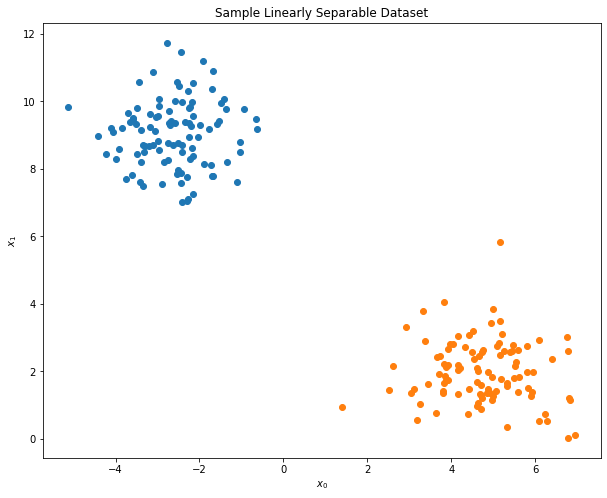

In [2]:
# import sample data
from sklearn.datasets import make_blobs

random_state = 42

X, y = make_blobs(
    n_samples=200,
    n_features=2,
    centers=2,
    cluster_std=1.0,
    shuffle=True,
    random_state=random_state,
)


def plot_sample_data(X, y, ax=None, title=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))
    if not title:
        title = "Sample Linearly Separable Dataset"

    for k in np.unique(y):
        ax.scatter(X[y == k, 0], X[y == k, 1])

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    ax.set_title(title)


plot_sample_data(X, y);

In [3]:
# SVC is sensitive to scaling - without this SVC and LinearSVC give different answers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC

lin_svc = LinearSVC(loss="hinge", random_state=random_state)
lin_svc.fit(X_scale, y)

svc = SVC(kernel="linear", random_state=random_state)
svc.fit(X_scale, y)

# alpha is regularisation parameter ~ 1/(mC)
# default value 0.0001 is so low it forces margins incredibly close
sgd_clf = SGDClassifier(
    loss="hinge",  # linear SVC
    alpha=0.007,
    random_state=random_state,
)
sgd_clf.fit(X_scale, y);

In [52]:
# for plotting decision boundaries and margins
def solve_linear_equation(intercept, coef, x0, cst=0, scaler=None):
    """
    Solves intercept + coef[0] * x0 + coef[1] * x1 = cst for x1.
    If solver provided, it solves in the scaled feature space and then maps back
    """
    if scaler:
        x0 = scaler.transform(np.c_[x0, np.zeros(len(x0))])[:, 0]

    x1 = cst - intercept - coef[0] * x0
    x1 /= coef[1]

    if scaler:
        x1 = scaler.inverse_transform(np.c_[np.zeros(len(x1)), x1])[:, 1]

    return x1

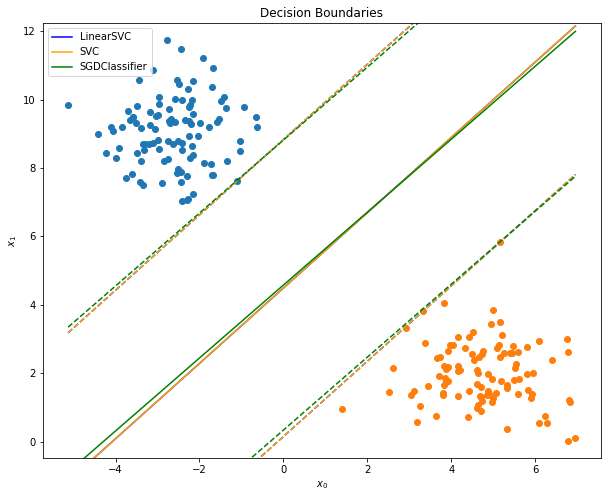

In [53]:
def plot_decision_boundary(clf, color, ax=None, label=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))

    if not label:
        label = "Decision Boundary"

    x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

    # decision boundary
    x1 = solve_linear_equation(clf.intercept_, clf.coef_[0], x0, scaler=scaler)

    # margins
    x1_neg = solve_linear_equation(
        clf.intercept_, clf.coef_[0], x0, cst=-1, scaler=scaler
    )
    x1_pos = solve_linear_equation(
        clf.intercept_, clf.coef_[0], x0, cst=1, scaler=scaler
    )

    ax.plot(x0, x1, color=color, label=label)
    ax.plot(x0, x1_neg, ls="--", color=color)
    ax.plot(x0, x1_pos, ls="--", color=color)


fig, ax = plt.subplots(figsize=(10, 8))

plot_sample_data(X, y, ax=ax, title="Decision Boundaries")

plot_decision_boundary(lin_svc, "blue", ax=ax, label="LinearSVC")
plot_decision_boundary(svc, "orange", ax=ax, label="SVC")
plot_decision_boundary(sgd_clf, "green", ax=ax, label="SGDClassifier")

y_min = X[:, 1].min() - 0.5
y_max = X[:, 1].max() + 0.5
ax.set_ylim(bottom=y_min, top=y_max)

ax.legend();

You can't distinguish between `SVC` and `LinearSVC` because they're on top of each other.